# **Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

## **Edición 2023**


----

# Trabajo práctico entregable - parte 2


En el ejercicio 1 de la parte 1 del entregable seleccionaron las filas y columnas relevantes al problema de predicción de precios de una propiedad. Además de ello, tuvieron que reducir el número de valores posibles para las variables categóricas utilizando información de dominio.

En el ejercicio 2 de la parte 1 del entregable imputaron los valores faltantes de las columnas `Suburb` y las columnas obtenidas a partir del conjunto de datos `airbnb`.

En esta notebook, **se utilizará resultado de dichas operaciones.**


In [372]:
import matplotlib.pyplot as plt
import numpy
import pandas

import seaborn
seaborn.set_context('talk')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

In [373]:
df = pandas.read_csv('merged_sales.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6561 entries, 0 to 6560
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6561 non-null   int64  
 1   Suburb               6561 non-null   object 
 2   Rooms                6561 non-null   int64  
 3   Type                 6561 non-null   object 
 4   Price                6561 non-null   float64
 5   Distance             6561 non-null   float64
 6   Postcode             6561 non-null   float64
 7   Bedroom2             6561 non-null   float64
 8   Bathroom             6561 non-null   float64
 9   Car                  6534 non-null   float64
 10  Landsize             6561 non-null   float64
 11  BuildingArea         6561 non-null   float64
 12  YearBuilt            6561 non-null   float64
 13  Lattitude            6561 non-null   float64
 14  Longtitude           6561 non-null   float64
 15  Propertycount        6561 non-null   f

In [374]:
df.head()

,Unnamed: 0,Suburb,Rooms,Type,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,zipcode,airbnb_price_mean,airbnb_record_count
0,0,Abbotsford,2,h,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0,3067.0,130.624031,258.0
1,1,Abbotsford,3,h,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0,3067.0,130.624031,258.0
2,2,Abbotsford,4,h,1600000.0,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0,3067.0,130.624031,258.0
3,3,Abbotsford,3,h,1876000.0,2.5,3067.0,4.0,2.0,0.0,245.0,210.0,1910.0,-37.8024,144.9993,4019.0,3067.0,130.624031,258.0
4,4,Abbotsford,2,h,1636000.0,2.5,3067.0,2.0,1.0,2.0,256.0,107.0,1890.0,-37.8060,144.9954,4019.0,3067.0,130.624031,258.0


## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas.
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


In [375]:
X = df.drop(['Price'], axis = 1)
y = df['Price']

Se separa la variable objetivo de las variables predictoras.

In [376]:
X = X[X['YearBuilt'] > 1900]

Se eliminan las edificaciones construidas antes del año 1900.

In [377]:
X['Suburb'].value_counts()

Bentleigh East    115
Brunswick         100
Coburg             98
Preston            97
Glenroy            93
                 ... 
Hurstbridge         1
McKinnon            1
Healesville         1
Warrandyte          1
Kooyong             1
Name: Suburb, Length: 299, dtype: int64

In [378]:
suburbios_frecuentes = X['Suburb'].value_counts().nlargest(30).index.tolist()
X = X[X['Suburb'].isin(suburbios_frecuentes)]

Dado el gran número de suburbios, y que varios de ellos poseen muy pocos registros, se seleccionaran sólo los treinta suburbios con mayor cantidad de filas.

In [379]:
X1 = X.drop(['Unnamed: 0', 'zipcode', 'Lattitude', 'Longtitude'], axis = 1)

Eliminamos varias columnas. zipcode es eliminada por ofrecer la misma informacion que postcode. Lattitude y Longitude se eliminan debido a que cada inmueble tiene identificado el barrio en el que se encuentra y la distancia al centro de Melbourne.

In [380]:
X1 = X1.drop(['BuildingArea', 'YearBuilt'], axis = 1)

In [381]:
categorical_cols = X1.select_dtypes(include = ['object']).columns.tolist()
numerical_cols = X1.select_dtypes(include = ['number']).columns.tolist()

Clasificamos las variables en categóricas y numéricas.

In [382]:
X1['Type'].value_counts()

h    1391
u     665
t     256
Name: Type, dtype: int64

In [383]:
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

new_columns = []

X_cat = encoder.fit_transform(X1[categorical_cols])
for col, col_values in zip(categorical_cols, encoder.categories_):
  for col_value in col_values:
    new_columns.append('{}={}'.format(col, col_value))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [384]:
X_enc = numpy.hstack([X_cat, X1[numerical_cols].values])
new_columns.extend(numerical_cols)

Aplicamos un encoder a las variables categóricas.

## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

In [385]:
append_cols = ['YearBuilt', 'BuildingArea']

X2 = numpy.hstack([X_enc, X[append_cols].values])
new_columns.extend(append_cols)

Agregamos las columnas YearBuilt y BuildingArea.

In [386]:
X2_df = pandas.DataFrame(X2, columns = new_columns)

In [387]:
X2_df.isna().sum()

Suburb=Balwyn North         0
Suburb=Bentleigh            0
Suburb=Bentleigh East       0
Suburb=Brighton             0
Suburb=Brighton East        0
Suburb=Brunswick            0
Suburb=Brunswick West       0
Suburb=Camberwell           0
Suburb=Carnegie             0
Suburb=Coburg               0
Suburb=Doncaster            0
Suburb=Elwood               0
Suburb=Essendon             0
Suburb=Footscray            0
Suburb=Glen Iris            0
Suburb=Glenroy              0
Suburb=Hawthorn             0
Suburb=Keilor East          0
Suburb=Kew                  0
Suburb=Malvern East         0
Suburb=Moonee Ponds         0
Suburb=Newport              0
Suburb=Northcote            0
Suburb=Pascoe Vale          0
Suburb=Preston              0
Suburb=Richmond             0
Suburb=South Yarra          0
Suburb=St Kilda             0
Suburb=Thornbury            0
Suburb=Yarraville           0
Type=h                      0
Type=t                      0
Type=u                      0
Rooms     

Chequeamos datos ausentes.

Los métodos de  imputación basados en similaridad o distancia pueden beneficiarse del escalado y de la estandarización. Las variables con escalas muy grandes pueden dominar el cálculo de las distancias, afectando negativamente las imputaciones.

In [388]:
standard = StandardScaler()
X2_df_standard = standard.fit_transform(X2_df)

scaler = MinMaxScaler()
X2_df_scaler = scaler.fit_transform(X2_df)

Realizamos estandarizado y escalado.

In [389]:
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
X2_standard_mice = mice_imputer.fit_transform(X2_df_standard)
X2_scaler_mice = mice_imputer.fit_transform(X2_df_scaler)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


KNN Imputer se usa para completar los datos ausentes prediciendo como deberían ser estos en función del dataset restantes. Las variables "YearBuilt" y "BuildingArea" "perdieron" los datos ausentes que tenía el dataset original en el proceso de eliminación de outliers. Por esta razón no se realiza el gráfico de comparación de la distribución de las variables antes y despues de la imputación.

In [390]:
# mice_year_built = df_data_mice.YearBuilt.to_frame()
# mice_year_built['Imputation'] = 'KNN over YearBuilt and BuildingArea'
# melb_year_build = melb_df.YearBuilt.dropna().to_frame()
# melb_year_build['Imputation'] = 'Original'
# data = pandas.concat([mice_year_built, melb_year_build])
# fig = plt.figure(figsize=(8, 5))
# g = seaborn.kdeplot(data=data, x='YearBuilt', hue='Imputation')

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

Si, es recomendable estandarizar o escalar las variables antes de aplicar PCA. PCA es sensible a la escala de las variables, las variables con valores desproporcionadamente altos puede afectar los componentes principales.

In [391]:
pca_standard = PCA(n_components = min(20, X2_standard_mice.shape[0]))
pca_scaler = PCA(n_components = min(20, X2_scaler_mice.shape[0]))

X2_standard_pca = pca_standard.fit_transform(X2_standard_mice)
X2_scaler_pca = pca_scaler.fit_transform(X2_scaler_mice)

explained_variance_standard = pca_standard.explained_variance_ratio_
explained_variance_scaler = pca_scaler.explained_variance_ratio_

df_pca_standard = pandas.DataFrame(X2_standard_pca, columns=[f'PC{i+1}' for i in range(pca_standard.n_components_)])
df_pca_scaler = pandas.DataFrame(X2_scaler_pca, columns=[f'PC{i+1}' for i in range(pca_scaler.n_components_)])

Aplicamos PCA sobre los dataset estanadarizados y escalados. Compararemos ambos resultados.

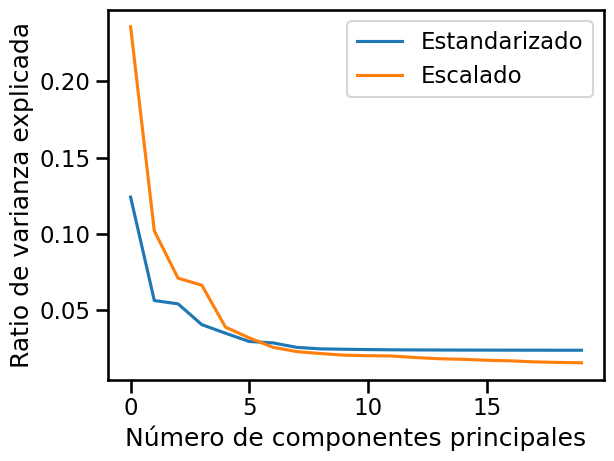

In [392]:
plt.plot(range(min(20, X2_standard_mice.shape[0])), explained_variance_standard, label = 'Estandarizado')
plt.plot(range(min(20, X2_scaler_mice.shape[0])), explained_variance_scaler, label = 'Escalado')
plt.xlabel('Número de componentes principales')
plt.ylabel('Ratio de varianza explicada')
plt.legend(loc = 'best')
plt.show()

Se seleccionaran el número de componentes que maximizan la varianza, en este caso ese número parece ser cinco.

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

In [393]:
X3 = pandas.DataFrame(X2_scaler_mice, columns = new_columns)

In [394]:
X4 = pandas.concat([X3, df_pca_scaler.iloc[:,0:5]], axis=1)
X4.head()

,Suburb=Balwyn North,Suburb=Bentleigh,Suburb=Bentleigh East,Suburb=Brighton,Suburb=Brighton East,Suburb=Brunswick,Suburb=Brunswick West,Suburb=Camberwell,Suburb=Carnegie,Suburb=Coburg,...,Propertycount,airbnb_price_mean,airbnb_record_count,YearBuilt,BuildingArea,PC1,PC2,PC3,PC4,PC5
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.244524,0.0,0.0,0.840708,0.410319,0.163887,0.949811,0.452944,0.476743,-0.187381
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.244524,0.0,0.0,0.398230,0.378378,-0.610365,0.009691,-0.046511,-0.173967,-0.102048
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.244524,0.0,0.0,0.486726,0.675676,-0.709034,0.048190,0.076249,-0.172360,-0.184112
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.244524,0.0,0.0,0.442478,0.454545,-0.651086,0.028769,-0.002019,-0.167819,-0.129212
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.244524,0.0,0.0,0.442478,0.528256,-0.661312,0.029701,0.008511,-0.168759,-0.138251


In [395]:
X4.to_csv('merged_sales_curated.csv')

Se construye el dataset final, el cual nace a partir de los datos escalados más los cinco primeros componentes principales.

## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso.


```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. Suburb: nombre del barrio. 299 valores posibles

  Se seleccionaron sólo los treinta varios con mayor número de filas. Ambas variables categóricas fueron codificadas con el método OneHotEncoding utilizando como máximo sus 30 valores.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Price: Valor de inmueble. Variable objetivo-
  3. Distance: Distancia al centro de la ciudad.
  4. Postcode: Código postal.
  5. Bedroom2: Número de habitaciones.
  6. Bathroom: Número de baños.
  7. Car: Número de lugares de estacionamiento.
  8. Landsize: Tamaño del terreno en metros.
  9. BuildingArea: Tamaño de la edificación en metros.
  10. YearBuilt: Año de construcción.
  11. Lattitude: Latitud.
  12. Longitude: Longitud.
  13. zipcode: Código postal.
  14. airbnb_price_mean: Precio promedio de alquiler.
  15. airbnb_record_count: Número de veces alquilado.

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas y escaladas.
  2. Los valores ausentes fueron imputados utiliando KNeighborsRegressor.
  3. Se aplicó análisis de componentes principales a los dataset estandarizados y escalados. Se selecionan los cinco primeros componentes principales.

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA al dataframe escalado.

  ### Guardado de los datos
  1. EL dataframe final fue exportado al archivo "merged_sales_curated.csv"    
```